# OBTENCION DE DATOS
**IMPORTAR LIBRERIAS Y OBTENER EL DATASET**

En primer lugar, importaremos las siguientes librerias necesarias para el analisis y procederemos a leer y mostrar el dataset.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

pd.set_option('display.max_columns', None)

In [ ]:
url ='https://raw.githubusercontent.com/simonzanetti/2023.2-SysArmy-IT-Salaries-Survey/main/dataset.csv'
df = pd.read_csv(url)

display(df.head(1))

#print("Shape: " + str(df.shape))
#print("\nColumn Names and Types: ")
#print(df.dtypes)

# PREPROCESAMIENTO
**ORDENAR COLUMNAS**

El primer paso de nuestra limpieza sera traducir al ingles el nombre de las columnas y eliminar aquellas que no sean relevantes para el analisis. Tambien ordene las columnas en las categorias:
- Empleado
- Trabajo
- Empresa
- Sueldo
- Herramientas
- Estudios

Las columnas eliminadas fueron:
- 'work_country': La totalidad de los encuestados es de Argentina
- 'ARS/USD_exchange': No solo que el porcentaje de los que cobra parte o la totalidad de su sueldo en dolares es pequeño, sino tambien que existen varios tipos de cotizacion y no se aclara cual se usa en cada caso, ademas que la cotizacion suele variar segun las semanas, horas o dias, por lo que es una variable inestable y he decidido eliminarla.
- 'is:number': Una variable que no vamos a utilizar.

In [4]:
columns_names = ['work_country','work_province','work_dedication','work_contract_type',
                'last_month_gross_salary','last_month_net_salary','salary_in_usd',
                'ARS/USD_exchange','salary_has_bonus','salary_bonus_tied_to',
                '2023_salary_adjusment_times','percentage_adjustment',
                'last_adjustment_month','last_semester_salary_comparison',
                'work_benefits','salary_satisfaction','work_title','years_experience',
                'years_in_company','years_in_position','people_in_charge','platforms',
                'programming_languages','frameworks','databases','qa_testing_tools',
                'company_size','work_mode','office_days_number(hybrid)','work_place_satisfaction',
                'AI_tools_use','finish_survey(1)','highest_level_studies','status','degree/specialization',
                'university/school','finish_survey(2)','work_on-call_duty','salary_on-call_duty',
                'is_number','finish_survey(3)','age','gender']

for i, nuevo_nombre in enumerate(columns_names):
    df.rename(columns={df.columns[i]: nuevo_nombre}, inplace=True)

salaries = pd.concat([df.iloc[:,0:2],df.iloc[:,41:],df.iloc[:,16],
                      df.iloc[:,2:4],df.iloc[:,17:21],df.iloc[:,26:30],
                      df.iloc[:,4:16],df.iloc[:,21:26],df.iloc[:,30:41]],axis=1)

salaries.drop(inplace=True, columns=[
                                    'work_country','ARS/USD_exchange','2023_salary_adjusment_times',
                                    'percentage_adjustment','last_adjustment_month',
                                    'last_semester_salary_comparison','finish_survey(1)','finish_survey(2)',
                                    'work_on-call_duty','salary_on-call_duty','is_number','finish_survey(3)'
                                    ])

display(salaries.head(0))

,work_province,age,gender,work_title,work_dedication,work_contract_type,years_experience,years_in_company,years_in_position,people_in_charge,company_size,work_mode,office_days_number(hybrid),work_place_satisfaction,last_month_gross_salary,last_month_net_salary,salary_in_usd,salary_has_bonus,salary_bonus_tied_to,work_benefits,salary_satisfaction,platforms,programming_languages,frameworks,databases,qa_testing_tools,AI_tools_use,highest_level_studies,status,degree/specialization,university/school


**LIMPIEZA Y TRANSFORMACION DE NANS**

In [6]:
print(salaries.isna().sum()) # Recargar celda para visualizar cambios

#SALARY_IN_USD
#print(salaries['salary_in_usd'].unique())
salaries['salary_in_usd'].fillna('No cobro mi salario en dolares',inplace=True)

#TOOLS
salaries.loc[:, 'platforms':'AI_tools_use'] = salaries.loc[:, 'platforms':'AI_tools_use'].fillna('Ninguna de las anteriores')

#STUDIES
#print(df['finish_survey(1)'].unique())
#print(df['highest_level_studies'].unique())
for columns in ('highest_level_studies','status','degree/specialization','university/school'):
    salaries.loc[(df['finish_survey(1)'] == 'Terminar encuesta') |
                 (df['finish_survey(1)'] == 'Responder sobre guardias'), columns] = 'Prefiero no responder'

for columns in ('degree/specialization','university/school'):
    salaries.loc[(df['highest_level_studies'] == 'Secundario'), columns] = 'Prefiero no responder'

work_province                   0
age                             0
gender                          0
work_title                      0
work_dedication                 0
work_contract_type              0
years_experience                0
years_in_company                0
years_in_position               0
people_in_charge                0
company_size                    0
work_mode                       0
office_days_number(hybrid)      0
work_place_satisfaction         0
last_month_gross_salary         0
last_month_net_salary         239
salary_in_usd                   0
salary_has_bonus                0
salary_bonus_tied_to            0
work_benefits                   0
salary_satisfaction             0
platforms                       0
programming_languages           0
frameworks                      0
databases                       0
qa_testing_tools                0
AI_tools_use                    0
highest_level_studies           0
status                          0
degree/special

**LIMPIEZA DE DUPLICADOS**


**NORMALIZACION DE VALORES**

En algunas columnas de este dataset nos encontraremos con una gran dispersion de opciones, con valores incorrectos o con valores que no representan de forma adecuada la respuesta del encuestado. Debido a ello necesitamos realizar una normalizacion de valores, en algunos casos en formato string y en otros casos en formato numerico.

Con la necesidad de reducir el tamaño del codigo, he creado una funcion que toma un dataset, una columna y un diccionario que contiene un mapeo regex, devolviendo un nuevo dataset normalizado.

Mediante el metodo pd.nunique() podemos ver la cantidad de opciones por cada variable, notando ciertas irregularidades:
- **'gender'**: Presenta 144 opciones diferentes de generos, lo cual nos muestra que exste una dispersion erronea en los datos.
- **'work title'**: Presenta una gran dispersion de valores.
- **'people_in_charge'**: Hay 58 opciones que varian entre 0 y 300. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.  
- **'company_size'**: Hay 11 categorias que varian entre 0 y 10000. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.
- **'office_days_number(hybrid)'**: Las opciones '0' y '5' no son correctas, ya que representan a los empleados que o no van nunca a la oficina o que van todos los dias, lo cual no condice con el modo de trabajo hibrido. Se necesita un analisis previo antes de normalizar.



In [7]:
def normalize_dataframe(df_in, column_name, regex_assign_map):
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        print("\nElementos de " + str.capitalize(column_name) + " que integran la categoria " + regex)
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        print(df_in[df_out[column_name].str.strip().str.match(compiled_regex, na=False)][column_name].unique())
        df_out.loc[mask, column_name] = value
    return df_out
print("Cantidad de valores que toma cada variable: ")
print(salaries.nunique())

Cantidad de valores que toma cada variable: 
work_province                   24
age                             58
gender                         144
work_title                     418
work_dedication                  2
work_contract_type               5
years_experience                59
years_in_company                50
years_in_position               46
people_in_charge                58
company_size                    11
work_mode                        3
office_days_number(hybrid)       6
work_place_satisfaction         11
last_month_gross_salary       2173
last_month_net_salary         2075
salary_in_usd                    4
salary_has_bonus                 5
salary_bonus_tied_to           216
work_benefits                 2101
salary_satisfaction              4
platforms                     1288
programming_languages         1446
frameworks                    1269
databases                     1195
qa_testing_tools               599
AI_tools_use                     6
highest_le

In [ ]:
#GENERO
#print(salaries['gender'].unique())

salaries = normalize_dataframe(salaries, 'gender',
    {
        "^(?!.*(mujer)).*hombre.*|.*macho.*|.*masculino.*|^(?!.*(?:trans|bi|\b(var[oó]n cis)\b))var[oó]n" : "Varón Cis",
        "^(?!.*(?:trans|bi|ag[eé]nero|var[oó]n)).*mujer" : "Mujer Cis",
        "^(?=.*mujer|var[oó]n)(?=.*trans)(?!.*nb).*" : "Trans",
        "^(?=.*mujer|var[oó]n)\b(bi)\b" : "Bisexual",
        ".*ag[eé]nero.*" : "Agenero",
        ".*ag[eé]nero.*" : "Agenero",
        ".*nb.*|.*no binario.*|.*no binarie.*" : "No binario",
    })

In [ ]:
#WORK_TITLE
print(salaries['work_title'].unique())

salaries1 = normalize_dataframe(salaries, 'work_title',
    {

    })

In [ ]:
#PEOPLE_IN_CHARGE
#ESPERAR ANALISIS
print(sorted(salaries['people_in_charge'].unique()))
#sns.countplot(x=salaries['people_in_charge'], color='steelblue')
sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')

['1 (solamente yo)', '1001 a 2000', '101 a 200', '11  a 50', '2 a 10', '2001a 5000', '201 a 500', '5001 a 10000', '501 a 1000', '51 a 100', 'Más de 10000']


<Axes: xlabel='count', ylabel='company_size'>

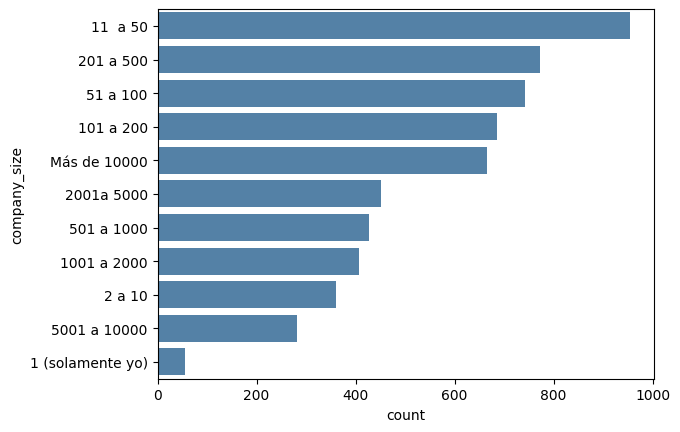

In [ ]:
#COMPANY_SIZE
#ESPERAR ANALISIS
salaries['company_size'] = salaries['company_size'].str.replace(r'\bDe\b|\bpersonas\b', '', regex=True).str.strip()
salaries['company_size'].replace({'1 (solamente yo)' : '1','11  a 50' : '11 a 50'})
print(sorted(salaries['company_size'].unique()))
sns.countplot(y=salaries['company_size'], color='steelblue',order=salaries['company_size'].value_counts().index)
#sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')

[0, 1, 2, 3, 4, 5]


<Axes: xlabel='work_mode', ylabel='office_days_number(hybrid)'>

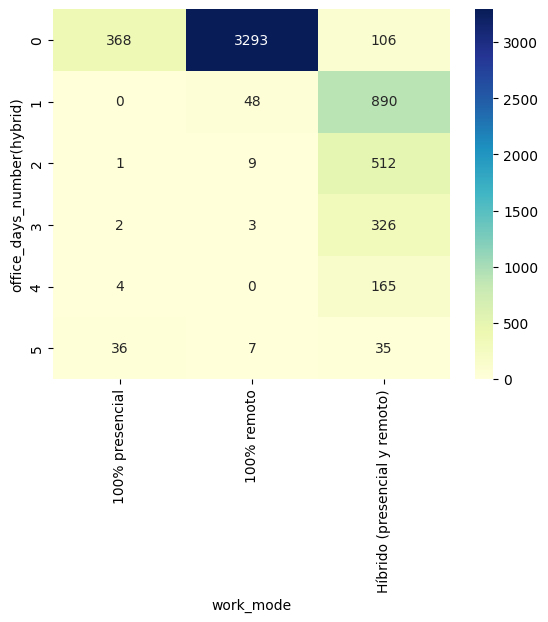

In [ ]:
#OFFICE_DAYS_NUMBER
#ESPERAR ANALISIS
print(sorted(salaries['office_days_number(hybrid)'].unique()))
#sns.countplot(y=salaries['office_days_number(hybrid)'], color='steelblue',order=salaries['office_days_number(hybrid)'].value_counts().index)
sns.heatmap(pd.crosstab(salaries['office_days_number(hybrid)'], salaries['work_mode']), annot=True, fmt='d', cmap='YlGnBu')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<Axes: xlabel='count', ylabel='work_place_satisfaction'>

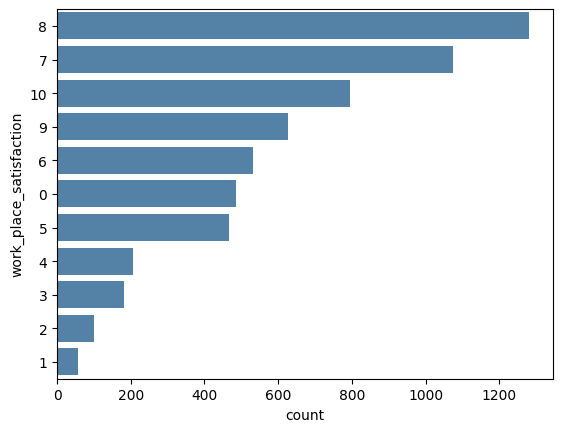

In [ ]:
#WORK_PLACE_SATISFACTION
print(sorted(salaries['work_place_satisfaction'].unique()))
sns.countplot(y=salaries['work_place_satisfaction'], color='steelblue',order=salaries['work_place_satisfaction'].value_counts().index)

In [ ]:
#LAST_MONTH_GROSS_SALARY AND LAST_MONTH_NET_SALARY

for index, valor in enumerate(salaries['last_month_gross_salary']):
    if not(np.isfinite(salaries.at[index,'last_month_gross_salary'])) or np.isnan(salaries.at[index,'last_month_gross_salary']):
        print(salaries.at[index,'last_month_gross_salary'])

def normalize_salaries(df_in,column):
    df_out = df_in.copy().astype(int)
    df_out = df_out.astype(str)
    df_out[column] = (df_out[column]
    .str.replace(".", "")
    .astype(int))
    return df_out



#salaries1 = normalize_salaries(salaries,'last_month_gross_salary')
display(salaries1['last_month_gross_salary'])
display(salaries['last_month_gross_salary'])
#LAST_MONTH_GROSS_SALARY
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.boxplot(x=salaries['last_month_gross_salary'], color='steelblue',ax=axes[0])
sns.boxplot(x=salaries1['last_month_gross_salary'], color='steelblue',ax=axes[1])

In [ ]:
#DEGREE/SPECIALIZATION
#print(salaries['degree/specialization'].unique())

salaries1 = normalize_dataframe(salaries, 'degree/specialization',
    {
        ".*ingenier[ií]a.* .*sistemas.*" : "Ingenieria en Sistemas",
        #".*ana.* .*sistema.* " : "Analista de Sistemas",
        ".*empresa.* " : "Administracion de Empresas",
        ".*economia.* " : "Lic. en Economia",
        ".*desarrollo.* .*web.*" : "Tec. en Desarrollo Web",
        ".*desarrollo.* .*movil.*" : "Tec. en Desarrollo de Aplicaciones Moviles",
        ".*desarrollo.* .*software.*" : "Tec. en Desarrollo de Software",
        ".*juego.* .*game.*" : "Tec. en Desarrollo de Videojuegos",
        "^(?!.*(?:higiene|lic|master|esp)).*seguridad.*" : "Tec. en Ciberseguridad/ Seguridad Informatica",
        "^(?!.*(?:higiene|tec|master|esp)).*seguridad.*" : "Lic. en Ciberseguridad/ Seguridad Informatica",
        ".*tec.* .*redes.*" : "Tec. en Redes Informaticas y Telecomunicaciones",
        ".*lic.* .*redes.*" : "Lic. en Redes Informaticas y Telecomunicaciones",
        "^(?!.*(?:sistema))(?=.*lic.* .*computaci[oó]n.*)" : "Lic. en Ciencia de la Computación",
        ".*ing.* .*computaci[oó]n.*" : "Ingeniería en Computación",
        ".*ana.* .*computaci[oó]n.*" : "Analista en Computación",
        ".*computaci[oó]n.*" : "Ingeniería en Computación",
        #".*dat.* " : "Tec. en Desarrollo de Software",
        #".*lic.* " : "Tec. en Desarrollo de Software",
        #"^(?!.*(?:robot|admin))(?=.*lic.*sistemas)" : "Licenciatura en Sistemas",
    })


In [ ]:
fig = plt.figure(figsize=(15, 60))
ax = sns.countplot(data=(salaries1['degree/specialization'].value_counts(normalize=True) * 100) > 10,y=salaries1['degree/specialization'], color='steelblue', order=salaries1["degree/specialization"].value_counts().index)
plt.title("Distribucion de encuestados por estudios",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

In [ ]:
print((salaries1['degree/specialization'].value_counts(normalize=True) * 100) > 0.5)